<a href="https://colab.research.google.com/github/zloelias/hse-project-vae-lstm/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install sranodec
!pip install skorch
!pip install pytorch-lightning

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sranodec import Silency
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pytorch_lightning as pl


In [4]:
class KPIDataset(Dataset):
    def __init__(self, X, label, window_len=256, sliding_step=1):
        self.start = 0
        self.window_len = window_len
        self.sliding_step = sliding_step
        #self.df = X
        timeseries = ((X.value - X.value.mean()) / X.value.std()).values
        W = self.normality_weights(X.value)
        temp = []
        temp_W = []
        self.label = label.values[self.window_len-1:-1]
        self.y = [] 
        for i in range(self.start, len(timeseries) - self.window_len*self.sliding_step, self.sliding_step):
            temp.append(
                torch.unsqueeze(torch.tensor(timeseries[i:i+self.window_len]), 0)
            )
            #self.label.append(
            #    label[i+self.window_len-1]
            #)
            self.y.append(
                timeseries[i+self.window_len]
            )
            temp_W.append(
                torch.unsqueeze(torch.tensor(W[i:i+self.window_len]), 0)
            )
        self.features = torch.Tensor(len(temp), self.window_len)
        self.W = torch.Tensor(len(temp_W), self.window_len)
        #self.label = torch.Tensor(len(temp_label), self.window_len)
        torch.cat(temp, out=self.features)
        #torch.cat(temp_label, out=self.label)
        torch.cat(temp_W, out=self.W)
        #self.W = torch.ones(len(temp), 1, self.window_len)
        #self.W = torch.rand((len(temp), 1, self.window_len))

    def normality_weights(self, x):
        window = 1440
        saliency = Silency(window // 8, window // 8, window * 2)
        #S = np.real(saliency.transform_silency_map(x))
        #D = (S - S.mean()) / S
        #W = 1 - 1 / (1 + np.exp(-(D - 5)))
        D = saliency.generate_anomaly_score(x, type='abs')
        W = 1 - 1 / (1 + np.exp(-(D - 4.1)))
        return W

    def __getitem__(self, i):
        return self.features[i].unsqueeze(dim=0), self.W[i].unsqueeze(dim=0), self.label[i], self.y[i]
    
    def __len__(self):
        return len(self.features)



In [99]:
DEBUG = False
window_len = 256

if DEBUG:
    BATCH_SIZE = 32768
else:
    BATCH_SIZE = 2048


In [100]:
 files = [
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/0.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/2.csv',         
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/4.csv',         
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/5.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/6.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/7.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/9.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/10.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/11.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/12.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/13.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/14.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/15.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/16.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/17.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/18.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/21.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/22.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/24.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/25.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/27.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/28.csv'
 ]

#files = [files[i] for i in range(0, len(files), 2)]

if DEBUG:
    files = [files[12]]

train_datasets = []
val_datasets = []
test_datasets = []

train_dataloaders = []
val_dataloaders = []
test_dataloaders = []

for file in files:
    df = pd.read_csv(file, index_col=0, header=0)
    y = df.label
    X = df.drop('label', axis=1).drop('KPI ID', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    train_datasets.append(KPIDataset(X_train, y_train, window_len=window_len, sliding_step=1))
    val_datasets.append(KPIDataset(X_val, y_val, window_len=window_len, sliding_step=1))
    test_datasets.append(KPIDataset(X_test, y_test, window_len=window_len, sliding_step=1))

    train_dataloaders.append(DataLoader(train_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))
    val_dataloaders.append(DataLoader(val_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))
    test_dataloaders.append(DataLoader(test_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))



/usr/local/lib/python3.7/dist-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


In [101]:
class CustomDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets

        self.map_indexes = [[] for _ in self.datasets]

        self.min_length = min(len(d) for d in self.datasets)
        self.max_length = max(len(d) for d in self.datasets)

    def __getitem__(self, i):
        return tuple(d[m[i]] for d, m in zip(self.datasets, self.map_indexes))

    def construct_map_index(self):
        def update_indices(original_indexes, target_len, max_len):
            # map max_len to target_len (large to small)

            # return: a list, which maps the range(max_len) to the valid index in the dataset
            
            original_indexes = original_indexes[max_len:] # remove used indices
            fill_num = max_len - len(original_indexes)
            batch = fill_num // target_len

            if fill_num % target_len != 0:
                # to let the fill_num + len(original_indexes) greater than max_len
                batch += 1

            additional_indexes = list(range(target_len)) * batch
            #random.shuffle(additional_indexes)

            original_indexes += additional_indexes

            assert len(original_indexes) >= max_len, "the length of matcing indexes is too small"

            return original_indexes

        self.map_indexes = [update_indices(m, len(d), self.max_length) 
            for m, d in zip(self.map_indexes, self.datasets)]

    def __len__(self):
        # will be called every epoch
        self.construct_map_index()
        return self.max_length

In [102]:
train_dataset = CustomDataset(train_datasets)
val_dataset = CustomDataset(val_datasets)
test_dataset = CustomDataset(test_datasets)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [104]:
class VAE(pl.LightningModule):
    def __init__(self, h_dim : int=128, z_dim : int=32, k : float=12, beta : float=.01, delay : int=7, use_weights : bool=True):
        super(VAE, self).__init__()
        self.k_ = k
        self.beta_ = beta
        self.delay_ = delay
        self.use_weights_ = use_weights
        self.x_groundtruth = np.array([])
        self.x_recon = np.array([])
        self.mae_recon = np.array([])
        self.std = np.array([])
        self.anomaly_groundtruth = np.array([])
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(16, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(32, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(64, 128, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Flatten(start_dim=1)
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (h_dim, 1)),
            nn.ConvTranspose1d(h_dim, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=4),
            nn.Tanhshrink(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=self.device)
        #print(f'esp {esp.shape}')
        #print(f'srt {std.shape}')
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        #print(f'mu: {mu.shape}')
        #print(f'logvar: {logvar}')
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #print(f'x {x.shape}')
        #print(f'h {h.shape}')
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z

    def step(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, recon_x, x, mu, logvar, w):
        if self.use_weights_:
            recon_loss = torch.mean(w * (recon_x - x) ** 2)#.mean()#weighted_mse_loss(recon_x, x, w)
            wk = w.mean()
        else:
            mse = nn.MSELoss()
            recon_loss = mse(x_recon, x)
            wk = 1
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + self.beta_ * wk * KLD
        logs = {
            "recon_loss": recon_loss,
            "kl": KLD,
            "loss": loss,
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log_dict({f'recon_mae_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            #if self.trainer.current_epoch > 5:
            #    print(self['recon_mae'])
        return loss

    def training_epoch_end(self, processed_epoch_output):
        self.eval_mae_std([self.trainer.logged_metrics[k].detach().item() for k in self.trainer.logged_metrics.keys() if k.find('recon_mae_') == 0])

    def validation_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log('val_loss', loss, on_epoch=True)
            self.log_dict({f'recon_mae_val_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.x_groundtruth = np.concatenate((self.x_groundtruth, x[:,0,-1].detach().cpu().numpy()))
            self.anomaly_groundtruth = np.concatenate((self.anomaly_groundtruth, l.detach().cpu().numpy()))
            self.x_recon = np.concatenate((self.x_recon, x_recon[:,0,-1].detach().cpu().numpy()))
            self.mae_recon = np.concatenate((self.mae_recon, torch.abs(x_recon[:,0,-1] - x[:,0,-1]).detach().cpu().numpy()))
            self.std = np.concatenate((self.std, torch.abs(x - x_recon).std(dim=2).squeeze().detach().cpu().numpy()))
        return loss

    def test_epoch_end(self, output):
        self.detect_anomaly()
        self.adjust_detected_anomaly()

    def detect_anomaly(self):
        self.anomaly_pointwise = (self.mae_recon > self.std*self.k_).astype(int)
        self.anomaly_pointwise[0:window_len] = 0

    def adjust_detected_anomaly(self):
        self.anomaly_adjusted = self.anomaly_pointwise
        i = 0
        while i < self.anomaly_groundtruth.shape[0]:
            if self.anomaly_groundtruth[i] == 0:
                i += 1
                continue
            else:
                # get anomaly len
                len = 1
                while self.anomaly_groundtruth[i+len] == 1:
                    len += 1
                # check detected anomaly in delay window
                if sum(self.anomaly_pointwise[i:i+self.delay_])>0:
                    self.anomaly_adjusted[i:i+len] = 1
                i += len
 
    def eval_mae_std(self, mae_arr):
        self.mae_std_ = np.std(mae_arr)

    def treshold(self):
        return self.k_ * self.mae_std_



In [105]:
class LSTM(pl.LightningModule):

    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        self.y_pred = np.array([])
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.3)
        
        self.fc1 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanhshrink()
        #self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=self.device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=self.device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)
        out = self.tanh(out)
        #out = self.fc2(out)
        
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, y_pred, y_true):
        mse_loss = nn.MSELoss(reduction='mean')
        eps = 1e-6
        rmse = ((mse_loss(y_pred.float(), y_true.float()) + eps)**0.5).float()
        mae = torch.mean(torch.abs(y_pred - y_true))
        return mse_loss(y_pred.float(), y_true.float()), rmse, mae



In [106]:
class VAE_LSTM(pl.LightningModule):

    def __init__(self, vae_h_dim=128, vae_z_dim=32, lstm_input_size=256, lstm_hidden_size=128, beta:float = .01, lmbda:float = 1, use_weights=True):
        super(VAE_LSTM, self).__init__()
        self.beta_ = beta
        self.lambda_ = lmbda
        self.use_weights_ = use_weights
        self.vae = VAE(h_dim=vae_h_dim, z_dim=vae_z_dim, beta=self.beta_)
        self.lstm = LSTM(lstm_input_size, lstm_hidden_size)
        
    def forward(self, x):
          x_recon, mu, logvar = self.vae.step(x)
          y_pred = self.lstm(x_recon).squeeze()
          return y_pred

    def step(self, x):
          x_recon, mu, logvar = self.vae.step(x)
          y_pred = self.lstm(x_recon).squeeze()
          return x_recon, y_pred, mu, logvar

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, x_recon, x, y_pred, y_true, mu, logvar, w):
        vae_loss, _ = self.vae.loss(x_recon, x, mu, logvar, w)
        mse, rmse, mae = self.lstm.loss(y_pred, y_true)
        if self.use_weights_:
            wk = w.mean()
        else:
            wk = 1
        loss = vae_loss + self.lambda_ * wk * mse
        logs = {
            "vae_loss": vae_loss,
            "mse": mse,
            "rmse": rmse,
            "mae": mae
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, y_pred, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, y_pred, y_true, mu, logvar, w)
            self.log_dict({f'recon_mae_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def training_epoch_end(self, processed_epoch_output):
        self.vae.eval_mae_std([self.trainer.logged_metrics[k].detach().item() for k in self.trainer.logged_metrics.keys() if k.find('recon_mae_') == 0])

    def validation_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, y_pred, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, y_pred, y_true, mu, logvar, w)
            self.log('val_loss', loss, on_epoch=True)
            self.log_dict({f'recon_mae_val_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, y_pred, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, y_pred, y_true, mu, logvar, w)
            self.vae.x_groundtruth = np.concatenate((self.vae.x_groundtruth, x[:,0,-1].detach().cpu().numpy()))
            self.vae.anomaly_groundtruth = np.concatenate((self.vae.anomaly_groundtruth, l.detach().cpu().numpy()))
            self.vae.x_recon = np.concatenate((self.vae.x_recon, x_recon[:,0,-1].detach().cpu().numpy()))
            self.vae.mae_recon = np.concatenate((self.vae.mae_recon, torch.abs(x_recon[:,0,-1] - x[:,0,-1]).detach().cpu().numpy()))
            self.vae.std = np.concatenate((self.vae.std, torch.abs(x - x_recon).std(dim=2).squeeze().detach().cpu().numpy()))
            self.lstm.y_pred = np.concatenate((self.lstm.y_pred, y_pred.detach().cpu().numpy()))
        return loss

    def test_epoch_end(self, output):
        self.vae.test_epoch_end(output)
        self.vae.adjust_detected_anomaly()


In [96]:
def plot_model(r_model, prediction=[], ts_start=-1, ts_end=-1, title=''):
    fig, ax = plt.subplots(figsize=(16, 8))

    if ts_start>=0 and  ts_end > 0:
        rng = range(ts_start, ts_end)
    else:
        rng = range(0, len(model.x_groundtruth))

    ts = range(len(r_model.x_groundtruth[rng]))
    ts_anomaly = np.argwhere(r_model.anomaly_groundtruth[rng] > 0).reshape(-1)
    pointwise_anomaly = np.argwhere(r_model.anomaly_adjusted[rng] > 0).reshape(-1)

    ax.plot(ts, r_model.x_groundtruth[ts], color='green', label='X')
    ax.plot(ts, r_model.x_recon[ts], color='blue', label='Reconstructed X')
    if len(prediction) > 0:
        ax.plot(ts, prediction[ts], color='yellow', label='Predicted X')
    ax.plot(ts_anomaly, [-3]*len(ts_anomaly), 'o', color='red', label='Groundtruth anomaly')
    ax.plot(pointwise_anomaly, [-4]*len(pointwise_anomaly), 'x', color='orange', label='Pointwise anomaly')
    ax.legend()
    ax.set_title(title)

    ax.grid()

    plt.show()


In [107]:
early_stop_callback = pl.callbacks.EarlyStopping(
   monitor='val_loss',
   min_delta=0.001,
   patience=5,
   verbose=False,
   mode='min'
)

if DEBUG:
    min_epochs, max_epochs, check_val_every_n_epoch = 10, 20, 1
    gpus = 1
else:
    min_epochs, max_epochs, check_val_every_n_epoch = 30, 200, 5
    gpus = 1


pad_trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=check_val_every_n_epoch, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs,
    auto_scale_batch_size='power',
    gradient_clip_val=0.8
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [108]:
# PAD

betas = [.01]
mse, rmse, mae = [], [], []
for beta in betas:
    pad_trainer = pl.Trainer(
        gpus=gpus, 
        callbacks=[early_stop_callback], 
        check_val_every_n_epoch=check_val_every_n_epoch, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs,
        auto_scale_batch_size='power',
        gradient_clip_val=0.8
    )
    model = VAE_LSTM(beta=beta)
    pad_trainer.fit(model, train_dataloader, val_dataloader)
    with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD{beta}.pcl', 'wb') as f:
        pickle.dump(model, f)
    mse.append(pad_trainer.logged_metrics['val_mse'].detach().item())
    rmse.append(pad_trainer.logged_metrics['val_rmse'].detach().item())
    mae.append(pad_trainer.logged_metrics['val_mae'].detach().item())


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


In [117]:
model.vae.k_ = 6
pad_trainer.test(model, test_dataloaders=test_dataloader)

print(f'F1-score: {f1_score(model.vae.anomaly_adjusted, model.vae.anomaly_groundtruth)}, Precision: {precision_score(model.vae.anomaly_adjusted, model.vae.anomaly_groundtruth)}, Recall: {recall_score(model.vae.anomaly_adjusted, model.vae.anomaly_groundtruth)}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
F1-score: 0.563532980404369, Precision: 0.4208096667370026, Recall: 0.8527571492150481


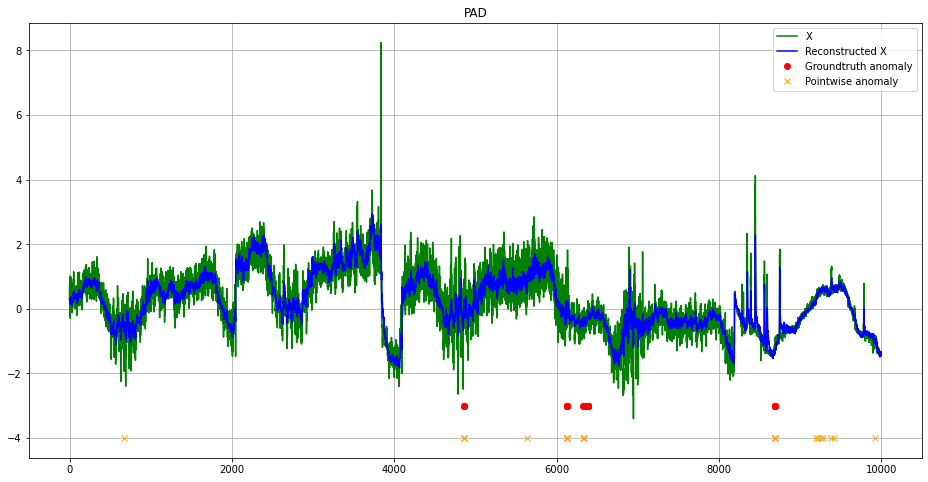

In [128]:
plot_model(model.vae, ts_start=30000, ts_end=40000, title='PAD')

In [129]:
# PAD

betas = [.1, 1, 10]
for beta in betas:
    pad_trainer = pl.Trainer(
        gpus=gpus, 
        callbacks=[early_stop_callback], 
        check_val_every_n_epoch=check_val_every_n_epoch, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs,
        auto_scale_batch_size='power',
        gradient_clip_val=0.8
    )
    model = VAE_LSTM(beta=beta)
    pad_trainer.fit(model, train_dataloader, val_dataloader)
    with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD{beta}.pcl', 'wb') as f:
        pickle.dump(model, f)
    mse.append(pad_trainer.logged_metrics['val_mse'].detach().item())
    rmse.append(pad_trainer.logged_metrics['val_rmse'].detach().item())
    mae.append(pad_trainer.logged_metrics['val_mae'].detach().item())


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


In [131]:
pd.DataFrame([mse, rmse, mae], index=['mse', 'rmse', 'mae'], columns=[.01, .1, 1, 10])

,0.01,0.10,1.00,10.00
mse,0.070972,0.068110,0.968462,0.993833
rmse,0.265458,0.259880,0.975788,0.995206
mae,0.208278,0.203816,0.836903,0.848258


In [119]:
beta = .01

In [120]:
PAD_no_weights = VAE_LSTM(beta=beta, use_weights=False)

pad_trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=check_val_every_n_epoch, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs,
    auto_scale_batch_size='power',
    gradient_clip_val=0.8
)

pad_trainer.fit(PAD_no_weights, train_dataloader, val_dataloader)

with open('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD_no_weights.pcl', 'wb') as f:
    pickle.dump(PAD_no_weights, f)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


In [121]:
PAD_no_weights.vae.k_ = 6

pad_trainer.test(PAD_no_weights, test_dataloaders=test_dataloader)

print(f'F1-score: {f1_score(PAD_no_weights.vae.anomaly_adjusted, PAD_no_weights.vae.anomaly_groundtruth)}, Precision: {precision_score(PAD_no_weights.vae.anomaly_adjusted, PAD_no_weights.vae.anomaly_groundtruth)}, Recall: {recall_score(PAD_no_weights.vae.anomaly_adjusted, PAD_no_weights.vae.anomaly_groundtruth)}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
F1-score: 0.08615644065274539, Precision: 0.045687682474552196, Recall: 0.7542336083369519


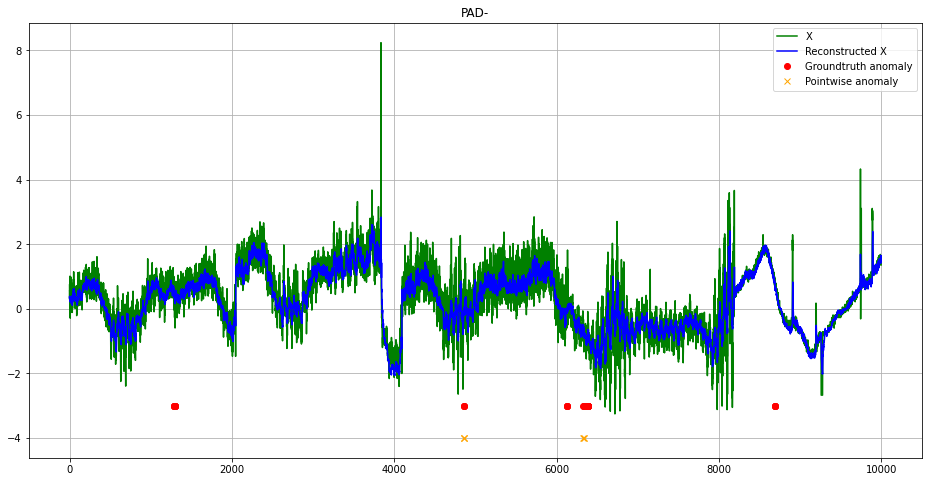

In [123]:
plot_model(PAD_no_weights.vae, ts_start=30000, ts_end=40000, title='PAD-')

In [124]:

trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=check_val_every_n_epoch, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs, 
    auto_scale_batch_size='power',
    gradient_clip_val=0.8
)

AD = VAE(beta=beta)
trainer.fit(AD, train_dataloader, val_dataloader)

with open('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/AD.pcl', 'wb') as f:
    pickle.dump(AD, f)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 43.3 K
1 | fc1     | Linear     | 4.1 K 
2 | fc2     | Linear     | 4.1 K 
3 | fc3     | Linear     | 4.2 K 
4 | decoder | Sequential | 43.2 K
---------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (30) or minimum steps (None) has not been met. Training will continue...


In [125]:
AD.k_ = 6
trainer.test(AD, test_dataloaders=test_dataloader)

print(f'F1-score: {f1_score(AD.anomaly_adjusted, AD.anomaly_groundtruth)}, Precision: {precision_score(AD.anomaly_adjusted, AD.anomaly_groundtruth)}, Recall: {recall_score(AD.anomaly_adjusted, AD.anomaly_groundtruth)}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
F1-score: 0.5216795615731786, Precision: 0.5133906146728354, Recall: 0.5302405592114245


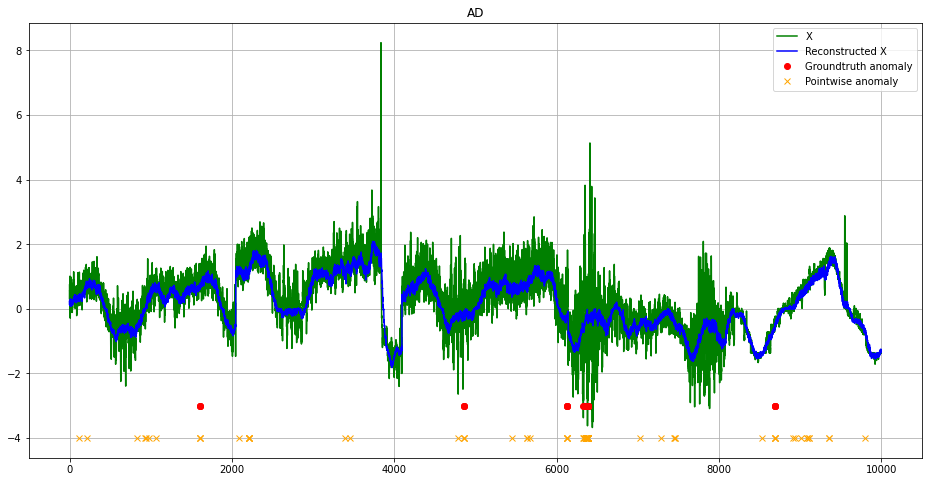

In [127]:
plot_model(AD, ts_start=30000, ts_end=40000, title='AD')

In [42]:
with open('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD0.01.pcl', 'rb') as f:
    model = pickle.load(f)

In [58]:
model.vae.k_ = 5.1

In [60]:
pad_trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=1, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs, 
    auto_scale_batch_size='power'
)

pad_trainer.test(model, test_dataloaders=test_dataloader)

print(f'F1-score: {f1_score(model.vae.anomaly_adjusted, model.vae.anomaly_groundtruth)}, Precision: {precision_score(model.vae.anomaly_adjusted, model.vae.anomaly_groundtruth)}, Recall: {recall_score(model.vae.anomaly_adjusted, model.vae.anomaly_groundtruth)}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
F1-score: 0.5120168250054391, Precision: 0.6572886215949504, Recall: 0.4193364456006557


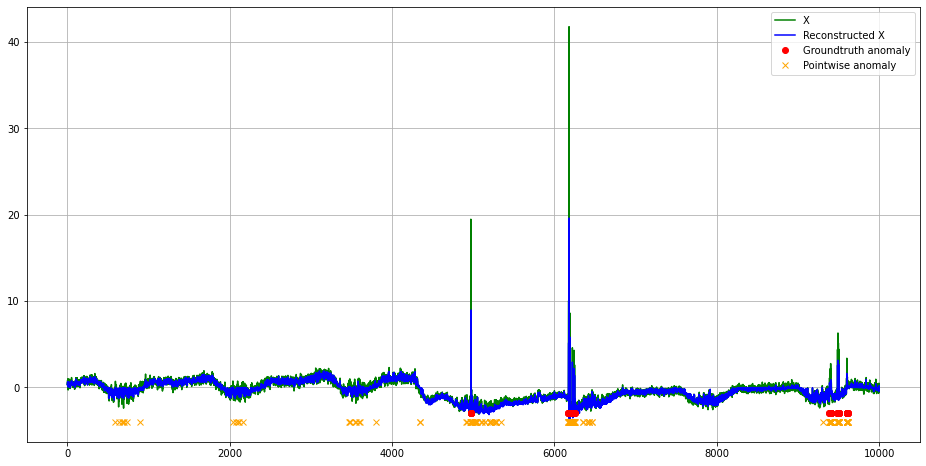

In [61]:
plot_model(model.vae, ts_start=0, ts_end=10000)

In [9]:
# AD    +
# P-AD
# PAD-  +
# PAD   +

